In [2]:
#import necessary python libraries
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import math
from JSON_to_DF import JSON_to_DataFrame
import Lightcurve_class
%matplotlib notebook

In [3]:
#Load data into a pandas dataframe for easier manipulation
df = JSON_to_DataFrame("../../../OSN_data/JSON_data/SN2011fe.json")



/Users/ethanmarx/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['band', 'source', 'telescope']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [4]:
#Define the Kapernka model for supernovae light curves
def Kapernka(t, A, B, t_0, t_1, Tfall, Trise):
	first = A * (1 + (B * (t - t_1)*(t - t_1)))
	var = -(t - t_0)
	second = np.exp(var / Tfall)
	third = 1 + np.exp(var / Trise)
	return first * (second / third)

In [5]:
def Newling(t, A, phi, sig, k, psi):
    tau = (k * sig) + phi
    psi_t = NaN
    if( t )
    
    
    first = (A * ((t - phi) / sig)*k)
    second = (np.exp(- (t - phi) / sigma))*(k*-k)*(np.exp(k))
    return (first * second) + 

SyntaxError: invalid syntax (<ipython-input-5-4c49748fbb41>, line 4)

In [6]:
#Create dictionaries to hold priors for model
priors = {
            'R' : [50, 20, 20, 50, 50, 50],
            'g' : [40,20,10,40,1,100],
            'I' : [100, 20, 20, 50, 50, 50]
          }
param_bounds = ([10*-5,10*-5,0,0,0,0], [1000,100,100,100,100,100])

In [7]:
#Define conversions for magnitude to flux, and mag error to flux errof
def mag_to_flux(mag):
    
    return 10**(-2*mag / 5) 

def mag_err_to_flux_err(mag, err, flux):
        
        mag_max = mag + err
        flux_max = mag_to_flux(mag_max)
        flux_error = flux_max - flux
        return flux_error

<IPython.core.display.Javascript object>


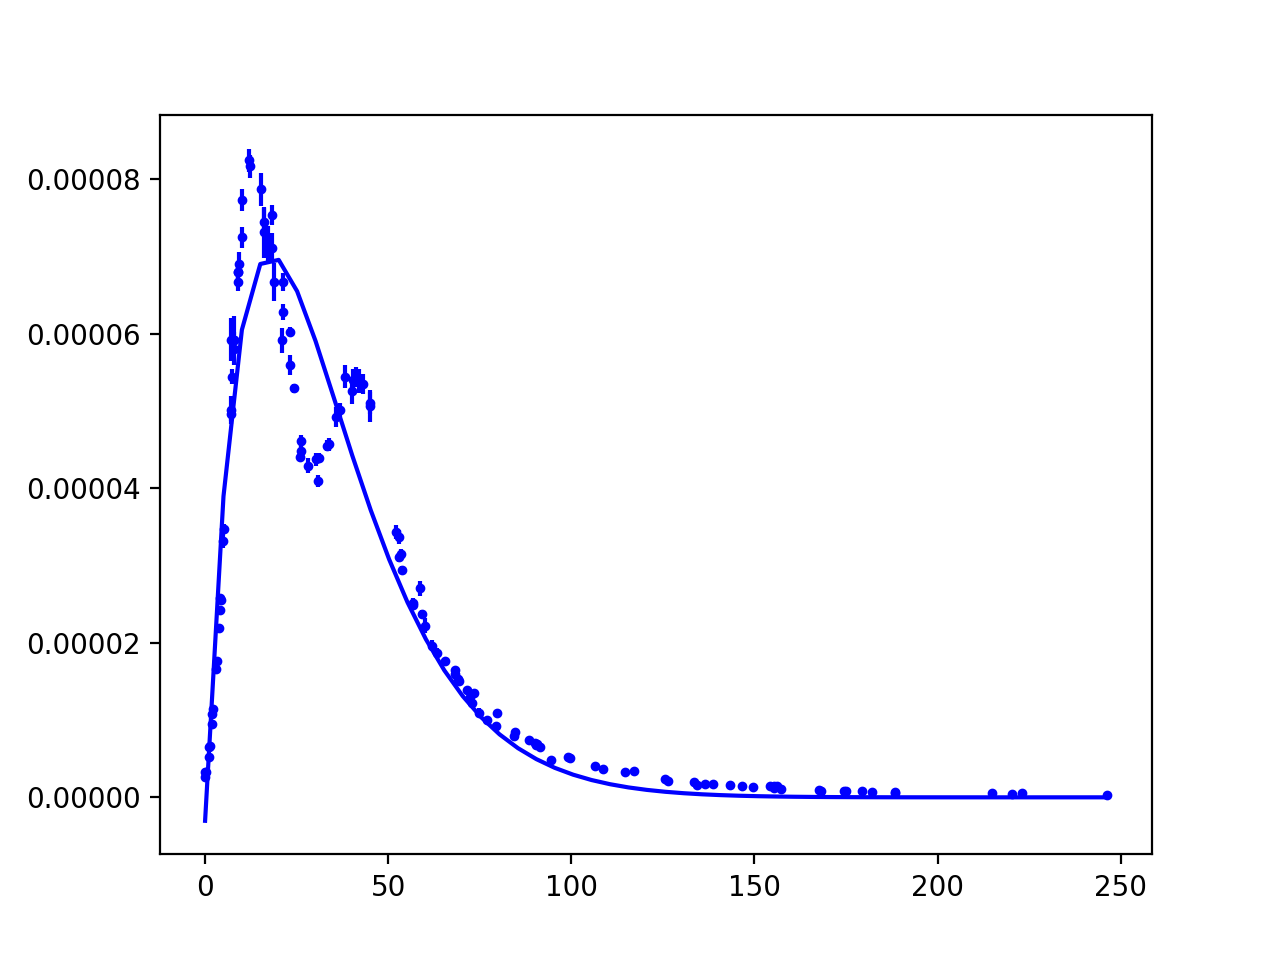

7.4369767583103968e-06

In [9]:
#convert magnitude to flux, and add that column to dataframe
df['flux'] = df.magnitude.apply(mag_to_flux)

#convert given errors to flux errors, and add that column to data frame
df['flux_error'] = df.apply(lambda row: mag_err_to_flux_err(row['magnitude'], row['e_magnitude'], row['flux']), axis=1)
df['flux_upper_error'] = df.apply(lambda row: mag_err_to_flux_err(row['magnitude'], row['e_upper_magnitude'], row['flux']), axis=1)
df['flux_lower_error'] = df.apply(lambda row: mag_err_to_flux_err(row['magnitude'], row['e_lower_magnitude'], row['flux']), axis=1)

#splice dataframe into three partitions according to band filter 
R_bools = (df.band == 'R')
R_data = df[R_bools]

I_bools = (df.band == 'I')
I_data = df[I_bools]

g_bools = (df.band == 'g')
g_data = df[g_bools]

sample = Lightcurve_class.Lightcurve(I_data.time.values, I_data.flux.values, I_data.flux_error.values, 'I', 'flux')
sample.Kapernka_fit_plot()

In [15]:
#get ride of outlier data point in g-band
g_data = g_data.drop(g_data.index[0])


In [16]:
#find minimum start time to shift.
start_time = min(R_data.time.iloc[0], I_data.time.iloc[0], g_data.time.iloc[0])

R_data.iloc[:,0] = R_data.time - start_time
g_data.iloc[:,0] = g_data.time - start_time
I_data.iloc[:,0] = I_data.time - start_time


/Users/ethanmarx/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
#Find best fit coefficients for the Kapernka model
fitCoeffs_I, Covars_I = curve_fit(Kapernka, I_data.time.values, I_data.flux.values , priors['I'], bounds=param_bounds)
fitCoeffs_g, Covars_g = curve_fit(Kapernka, g_data.time.values, g_data.flux.values, priors['g'], bounds=param_bounds)
fitCoeffs_R, Covars_R = curve_fit(Kapernka, R_data.time.values, R_data.flux.values , priors['R'], bounds=param_bounds)


In [18]:
#create array of evenly spaced time intervals
bft_I = np.linspace(I_data.time.iloc[0], I_data.time.iloc[-1], 500)
bft_g = np.linspace(g_data.time.iloc[0], g_data.time.iloc[-1], 500)
bft_R = np.linspace(R_data.time.iloc[0], R_data.time.iloc[-1], 500)

In [19]:
bestfit_flux_I = Kapernka(bft_I, fitCoeffs_I[0], fitCoeffs_I[1], fitCoeffs_I[2], fitCoeffs_I[3], fitCoeffs_I[4],fitCoeffs_I[5])

bestfit_flux_g = Kapernka(bft_g, fitCoeffs_g[0], fitCoeffs_g[1], fitCoeffs_g[2], fitCoeffs_g[3], fitCoeffs_g[4],fitCoeffs_g[5])

bestfit_flux_R = Kapernka(bft_R, fitCoeffs_R[0], fitCoeffs_R[1], fitCoeffs_R[2], fitCoeffs_R[3], fitCoeffs_R[4],fitCoeffs_R[5])

In [20]:

plt.errorbar(I_data.time.values, I_data.flux.values, yerr=I_data.flux_error.values, color='blue', label= 'I', fmt = 'o', markersize = 2.5)
plt.errorbar(g_data.time.values, g_data.flux.values, yerr=g_data.flux_upper_error.values, color='green', label= 'g', fmt = 'o', markersize = 2.5)
plt.errorbar(R_data.time.values, R_data.flux.values, yerr=R_data.flux_error.values, color='red', label= 'R', fmt = 'o', markersize = 2.5)
plt.plot(bft_I, bestfit_flux_I, color = 'blue', label ='best fit')
plt.plot(bft_g, bestfit_flux_g, color = 'green', label = 'best fit')
plt.plot(bft_R, bestfit_flux_R, color = 'red', label = 'best fit')
ax = plt.gca()
ax.set_ylim([-0.000001, np.amax(R_data.flux.values) + .00001])
plt.legend(ncol=2)
plt.title('SN2011fe light curves')
plt.xlabel('time (days)')
plt.ylabel('relative flux')

plt.show()

<IPython.core.display.Javascript object>


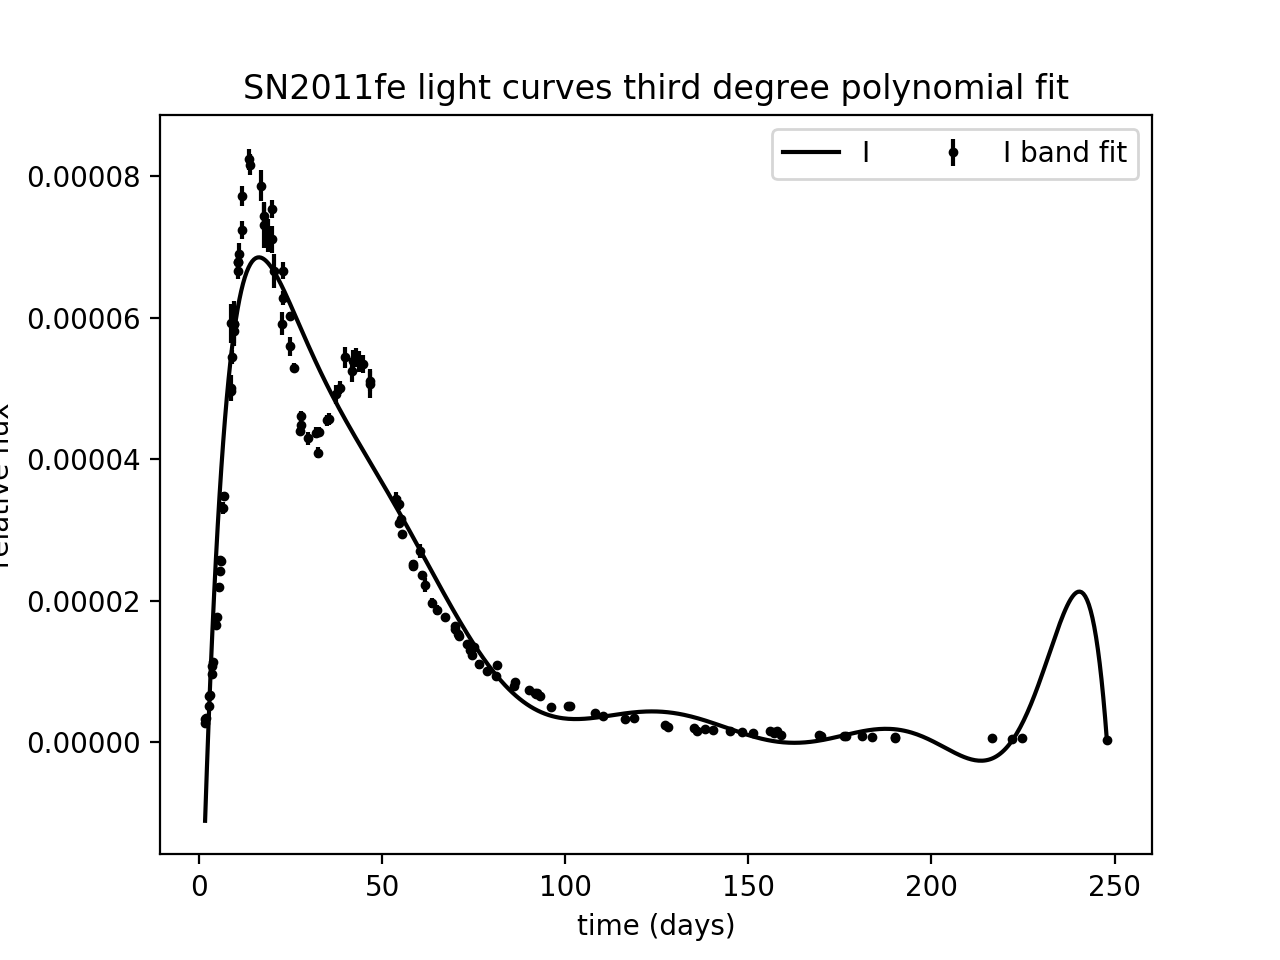

In [34]:
plt.close()
def polynomial_fit_plot(degree, flux, times, errors, band):
    Coeffs3 = np.polyfit(times, flux, degree)
    f3 = np.poly1d(Coeffs3)
    
    bft = np.linspace(times[0], times[-1], 500)
    plt.plot(bft, f3(bft), color='black', label=band)
    plt.errorbar(times, flux, yerr=errors, fmt='o', color='black', markersize=2.5, label='I band fit')

    plt.legend(ncol=2)
    plt.title('SN2011fe light curves third degree polynomial fit')
    plt.xlabel('time (days)')
    plt.ylabel('relative flux')
    plt.show()


polynomial_fit_plot(10, I_data.flux.values, I_data.time.values, I_data.flux_error.values, 'I')


# K-fold cross validation analysis and root mean squared error calculation

In [10]:
def calc_RMSE(flux, times, flux_errors, band, fit):
    flux_predictions = []
    #loop to run 'leave one out' CV
    for ind, f in enumerate(flux):
        flux_del = np.delete(flux, ind)
        times_del = np.delete(times, ind)
        Coeffs, Covar = curve_fit(fit, times_del, flux_del, priors[band], bounds= param_bounds)
        ypred = fit(times[ind], Coeffs[0], Coeffs[1], Coeffs[2], Coeffs[3], Coeffs[4], Coeffs[5])
        flux_predictions.append(ypred)

    flux_predictions = np.array(flux_predictions)
    
    #Root Mean Square Error calculations
    dif = (flux_predictions - flux)/flux_errors
    temp = np.sum((flux_predictions - flux)**2)
    temp = temp / (len(flux))
    RMSE = np.sqrt(temp)
    return RMSE


print(calc_RMSE(I_data.flux.values, I_data.time.values, I_data.flux_error.values, "I", Kapernka)) 
print(calc_RMSE(g_data.flux.values, g_data.time.values, g_data.flux_error.values, 'g', Kapernka))
print(calc_RMSE(R_data.flux.values, R_data.time.values, R_data.flux_error.values, 'R', Kapernka))

3.80203633369e-05
2.45527400617e-05
4.181858384e-05
